In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

2026-01-04 02:07:31.841351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/niku/github/Neural_Netowrk/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# GPUメモリ動的確保（スタベーション対策）
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# 高速化設定 (Mixed Precision)
mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision Policy:", mixed_precision.global_policy())

print("TensorFlow Version:", tf.__version__)

Mixed Precision Policy: <DTypePolicy "mixed_float16">
TensorFlow Version: 2.20.0


In [4]:
# 2. FLOPs計算関数 

def calculate_flops(model):
    input_signature = [tf.TensorSpec(shape=(1,) + model.input_shape[1:], dtype=tf.float32)]
    full_model = tf.function(lambda x: model(x))
    concrete_func = full_model.get_concrete_function(input_signature)
    frozen_func, _ = convert_variables_to_constants_v2_as_graph(concrete_func)
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph,
        run_meta=run_meta, 
        cmd='op', 
        options=opts
    )
    return flops.total_float_ops

In [5]:
# 3. データセット準備 (CPU負荷分散版)
BATCH_SIZE = 16
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 正規化
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# データ拡張関数 (tf.imageを使用)
def augment(image, label):
    image = tf.image.resize(image, [64, 64])  # 32x32 → 64x64
    image = tf.image.random_flip_left_right(image)  # これも入れた方が良い
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# パイプライン構築
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(5000) \
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

# テストデータもリサイズが必要
def resize_only(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(resize_only, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE) \
    .prefetch(tf.data.AUTOTUNE)

/home/niku/github/Neural_Netowrk/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")
I0000 00:00:1767460066.597318     806 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1767460066.599174     806 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2026-01-04 02:07:46.604045: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.
2026-01-04 02:07:48.742528: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.


In [6]:
# 4. ResNet50V2 モデル定義 

# ボトルネック構造 (1x1 -> 3x3 -> 1x1)
def bottleneck_block(x, filters, stride=1):
    shortcut = x
    # Pre-activation BN -> ReLU
    pre_act = layers.BatchNormalization()(x)
    pre_act = layers.Activation("relu")(pre_act)

    # ショートカット側の調整 (サイズやチャンネル数が変わる場合)
    if stride > 1 or x.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride, use_bias=False)(pre_act)

    # --- Main Path ---
    # 1x1 Conv (圧縮)
    m = layers.Conv2D(filters, 1, use_bias=False)(pre_act)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)

    # 3x3 Conv (特徴抽出)
    # ResNetV2ではここでstrideを適用
    m = layers.ZeroPadding2D(padding=1)(m)
    m = layers.Conv2D(filters, 3, strides=stride, use_bias=False)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation("relu")(m)

    # 1x1 Conv (復元)
    m = layers.Conv2D(filters * 4, 1, use_bias=False)(m)

    # Add
    return layers.Add()([shortcut, m])

def build_resnet50_v2(input_shape=(32, 32, 3), classes=10):
    inputs = layers.Input(input_shape)

    # Stem (最初の入力処理)
    # CIFAR-10は画像が小さいので、最初の7x7ConvとMaxPoolingは
    # 3x3Convなどに置き換えることが多いが、ここでは標準ResNetに準拠しつつstride調整
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    # x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # 32x32だと小さくなりすぎるので削除推奨

    # ResNet50のステージ構成: [3, 4, 6, 3] blocks
    # Stage 1
    for _ in range(3):
        x = bottleneck_block(x, 64, stride=1)
    
    # Stage 2
    x = bottleneck_block(x, 128, stride=2) # ダウンサンプリング
    for _ in range(3):
        x = bottleneck_block(x, 128, stride=1)

    # Stage 3
    x = bottleneck_block(x, 256, stride=2)
    for _ in range(5):
        x = bottleneck_block(x, 256, stride=1)

    # Stage 4
    x = bottleneck_block(x, 512, stride=2)
    for _ in range(2):
        x = bottleneck_block(x, 512, stride=1)

    # Head
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # 出力層 (Mixed Precision用にfloat32指定)
    outputs = layers.Dense(classes, activation="softmax", dtype='float32')(x)

    return models.Model(inputs, outputs, name="ResNet50V2_Baseline")

In [7]:
# 5. モデル構築とFLOPs測定
model = build_resnet50_v2(input_shape=(64, 64, 3), classes=10)

print("\n" + "="*40)
print("【Baseline (Normal) モデル計算量】")
print("="*40)
try:
    flops_val = calculate_flops(model)
    params = model.count_params()
    print(f"パラメータ数: {params:,}")
    print(f"FLOPs: {flops_val / 10**9:.4f} G (ギガ)")
except Exception as e:
    print(f"FLOPs計算エラー: {e}")
print("="*40 + "\n")


【Baseline (Normal) モデル計算量】


/home/niku/github/Neural_Netowrk/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 64, 64, 3))']
  warnings.warn(msg)
I0000 00:00:1767460074.438137     806 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1767460074.438559     806 single_machine.cc:376] Starting new session
I0000 00:00:1767460074.439715     806 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation ker

In [8]:
# 6. 学習実行
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


2026-01-04 02:08:06.756866: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 614400000 exceeds 10% of free system memory.
2026-01-04 02:08:48.850231: I external/local_xla/xla/service/service.cc:163] XLA service 0x789c54004280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 02:08:48.850314: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2026-01-04 02:08:49.781540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-04 02:08:58.020212: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-04 02:09:17.178070: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f16[128,3,3,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,64,64,128

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 337s 73ms/step - accuracy: 0.4200 - loss: 1.5693 - val_accuracy: 0.5536 - val_loss: 1.2622
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - accuracy: 0.6296 - loss: 1.0436 - val_accuracy: 0.5989 - val_loss: 1.1619
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 222s 71ms/step - accuracy: 0.6987 - loss: 0.8521 - val_accuracy: 0.7129 - val_loss: 0.8319
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 221s 71ms/step - accuracy: 0.7490 - loss: 0.7172 - val_accuracy: 0.7738 - val_loss: 0.6629
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 220s 71ms/step - accuracy: 0.7860 - loss: 0.6129 - val_accuracy: 0.7656 - val_loss: 0.6721
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 220s 70ms/step - accuracy: 0.8143 - loss: 0.5371 - val_accuracy: 0.7952 - val_loss: 0.5947
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 220s 70ms/step - accuracy: 0.8355 - loss: 0.4745 - val_accuracy: 0.7956 - val_loss: 0.5959
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 220s 70ms/step - accuracy: 0.8538 - lo

In [9]:
# 7. 結果の可視化（個別保存版）
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

print(f"\n{'='*50}")
print(f"学習終了: 全{len(acc)}エポック (0-{len(acc)-1})")
print(f"最終 Val Accuracy: {val_acc[-1]:.4f}")
print(f"最終 Val Loss: {val_loss[-1]:.4f}")
print(f"{'='*50}\n")


学習終了: 全29エポック (0-28)
最終 Val Accuracy: 0.8096
最終 Val Loss: 1.0046



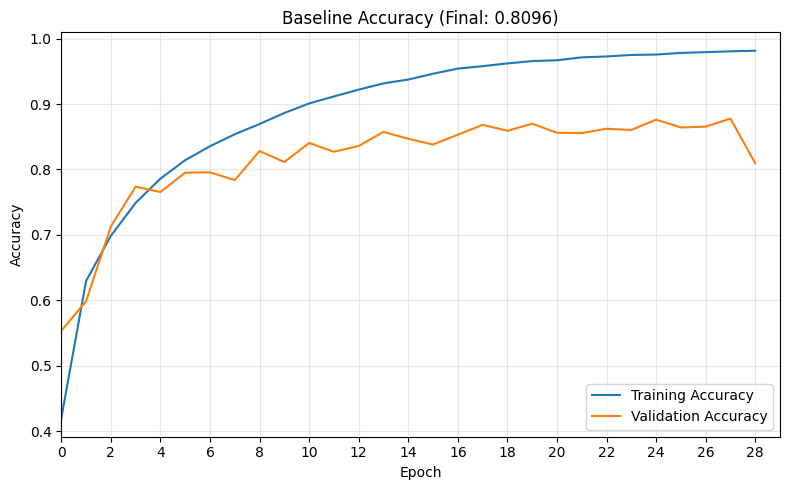

In [15]:
# Accuracyグラフ
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Baseline Accuracy (Final: {val_acc[-1]:.4f})')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(acc))
plt.xticks(range(0, len(acc), 2))
plt.tight_layout()
plt.savefig('baseline_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()


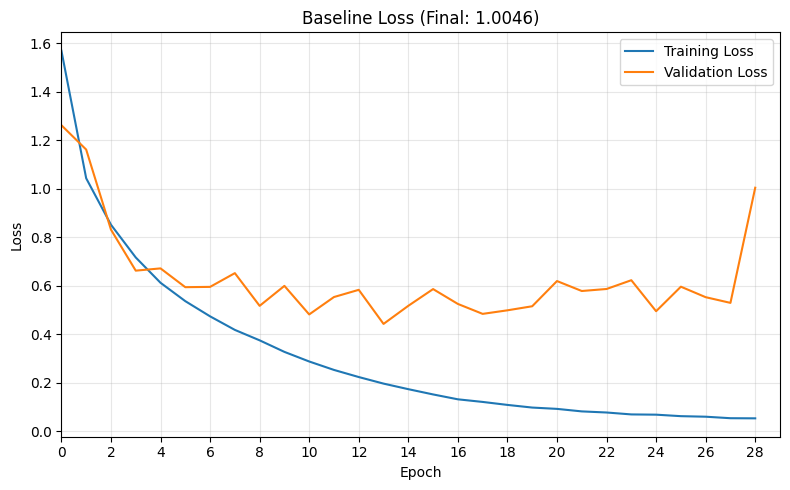

In [13]:
# Lossグラフ
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Baseline Loss (Final: {val_loss[-1]:.4f})')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, len(acc))
plt.xticks(range(0, len(acc), 2))
plt.tight_layout()
plt.savefig('baseline_loss.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# 保存（後の比較用）
model.save("resnet50v2_baseline.h5")
print("\n保存完了:")
print("  - baseline_accuracy.png")
print("  - baseline_loss.png")
print("  - resnet50v2_baseline.h5")


保存完了:
  - baseline_accuracy.png
  - baseline_loss.png
  - resnet50v2_baseline.h5
